In [ ]:
# Importing and loading the BreastMNIST dataset
# Installs the medmnist library (collection of preprocessed medical imaging datasets) & tools to load them easily

#======================================
# Core Python and Utilities
import numpy as np
import matplotlib.pyplot as plt
#======================================

import medmnist # imports the medmnist package (datasets and helper functions) into the python session
from medmnist import INFO, Evaluator # (INFO is a dict that stores metadata for medmnist datasets; Evaluator is a helper class to evaluate model performance[eg. accuracy, AUC] on a given dataset)
# Torchvision (transforms, etc)
from torchvision import transforms # transforms provides a way to preprocess images before feeding them into a neural network (converts images to tensors, resizes, normalizes, does data augmentation)
#======================================

# PyTorch
import torch
from torch.utils.data import DataLoader, random_split # used to load data in batches and shuffle it for training.
import torch.nn as nn
import torch.optim as optim
#======================================

# Metrics/ Evaluation
from sklearn.metrics import classification_report, confusion_matrix
#======================================

data_flag = 'breastmnist' # tells MedMNIST which dataset I want. Will be used to access metadata next
info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class']) # gets the name of the class that loads the dataset from the medmnist module

In [12]:
# Preprocessing

# convert the image from pIL/NumPy array into a PyTorch tensor & normalize the data to speed up training and stabilize gradient updates.
data_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[.5], std=[.5])])

# Load train and test sets
train_dataset = DataClass(split='train', transform=data_transform, download=True)
test_dataset = DataClass(split='test', transform=data_transform, download=True)


Using downloaded and verified file: /Users/jessica./.medmnist/breastmnist.npz
Using downloaded and verified file: /Users/jessica./.medmnist/breastmnist.npz


In [13]:
label_names = {
    0: "benign/normal",
    1: "malignant"
}

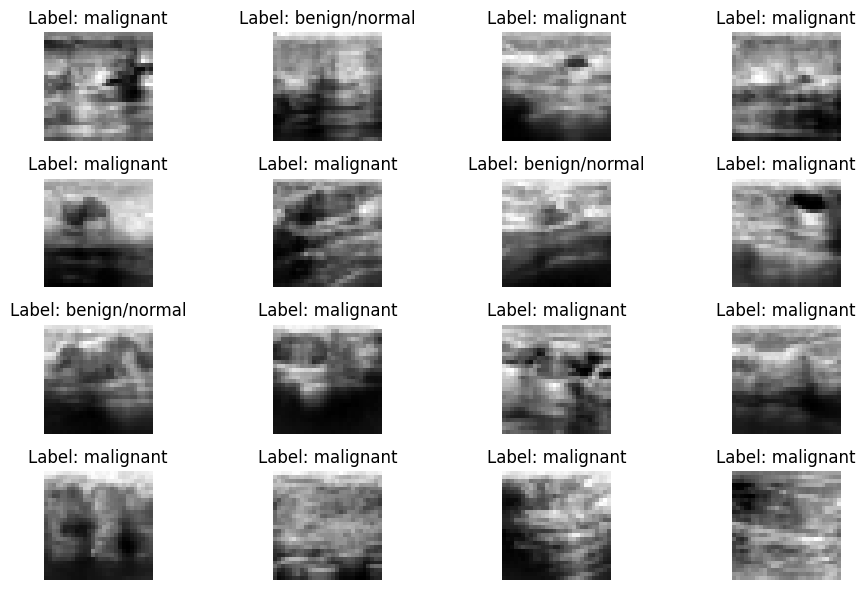

In [14]:
# Visualize a grid of BreastMNIST samples (denormalized)
import torch
import matplotlib.pyplot as plt

# 1) make sure we have a loader (uses existing one if present)
try:
    _ = train_loader
except NameError:
    from torch.utils.data import DataLoader
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# 2) grab one mini-batch
images, labels = next(iter(train_loader))   # images: [B, 1, 28, 28], labels: [B, 1] or [B]
labels = labels.squeeze()                   # make sure labels are shape [B]

# 3) quick denormalize for display if it was Normalized([0.5],[0.5])
def denorm(x):
    # x is a tensor in [-1, 1] after Normalize(mean=0.5, std=0.5)
    return x * 0.5 + 0.5  # back to [0,1]

# 4) plot a grid
n = min(16, images.size(0))  # show up to 16
plt.figure(figsize=(10, 6))
for i in range(n):
    plt.subplot(4, 4, i + 1)
    img = denorm(images[i]).squeeze(0).cpu().numpy()  # [28,28] for grayscale
    plt.imshow(img, cmap="gray")

    # use label_names instead of raw int
    plt.title(f"Label: {label_names[int(labels[i])]}")
    plt.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
# Splitting the data into training and validation sets

train_size = int(0.85 * len(train_dataset)) # total num of samples in the training dataset(keeps 85% for training)
val_size = len(train_dataset) - train_size # the remaining 15% are used for validation (validation data is used during training to tune hyperparameters and check for overfitting)
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size]) # randomly splits the dataset into 2 subsets (85% of the data[train] & 15% [val])

In [ ]:
# Building the CNN Model
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1), # input is grayscale
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 7 * 7, 128),
            nn.ReLU(),
            nn.Linear(128, 2) # binary classification
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x
        
        

In [ ]:
# Training the model


# Data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

# Device (GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using:", device)

# Instantiate model, loss, optimizer
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


# Early stopping class
class EarlyStopping:
    def __init__(self, patience=3):
        self.patience = patience
        self.best_loss = float('inf')
        self.counter = 0
        self.best_state = None
        self.early_stop = False

    def step(self, val_loss, model):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
            self.best_state = model.state_dict()
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

early_stopper = EarlyStopping(patience=3)

# Training loop
for epoch in range(20):
    model.train()
    train_loss = 0
    for X, y in train_loader:
        X, y = X.to(device), y.squeeze().to(device)  # y squeeze to correct shape
        optimizer.zero_grad()
        output = model(X)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * X.size(0)
    train_loss /= len(train_loader.dataset)

    # Validation
    model.eval()
    val_loss = 0
    correct = 0
    with torch.no_grad():
        for X, y in val_loader:
            X, y = X.to(device), y.squeeze().to(device)
            output = model(X)
            loss = criterion(output, y)
            val_loss += loss.item() * X.size(0)
            preds = output.argmax(dim=1)
            correct += (preds == y).sum().item()
    val_loss /= len(val_loader.dataset)
    val_acc = correct / len(val_loader.dataset)
    
    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
    
    early_stopper.step(val_loss, model)
    if early_stopper.early_stop:
        print('Early stopping triggered')
        break

# Loading best model
model.load_state_dict(early_stopper.best_state)
print("Training complete.")


Using: cpu
Epoch 1, Train Loss: 0.5973, Val Loss: 0.5907, Val Acc: 0.7073
Epoch 2, Train Loss: 0.5604, Val Loss: 0.5613, Val Acc: 0.7073
Epoch 3, Train Loss: 0.5254, Val Loss: 0.5172, Val Acc: 0.7073
Epoch 4, Train Loss: 0.5002, Val Loss: 0.5033, Val Acc: 0.7561
Epoch 5, Train Loss: 0.4790, Val Loss: 0.5032, Val Acc: 0.7805
Epoch 6, Train Loss: 0.4610, Val Loss: 0.5054, Val Acc: 0.7805
Epoch 7, Train Loss: 0.4401, Val Loss: 0.5053, Val Acc: 0.7195
Epoch 8, Train Loss: 0.4365, Val Loss: 0.5050, Val Acc: 0.7927
Early stopping triggered
Training complete.


In [ ]:
# Evaluate the model

test_loader = DataLoader(test_dataset, batch_size=64)

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for X, y in test_loader:
        X, y = X.to(device), y.squeeze().to(device)
        output = model(X)
        preds = output.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

print(classification_report(all_labels, all_preds))
cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:\n", cm)

# Save and load the model

torch.save(model.state_dict(), 'models/breastmnist_cnn.pth')

              precision    recall  f1-score   support

           0       0.84      0.38      0.52        42
           1       0.81      0.97      0.88       114

    accuracy                           0.81       156
   macro avg       0.83      0.68      0.70       156
weighted avg       0.82      0.81      0.79       156

Confusion Matrix:
 [[ 16  26]
 [  3 111]]
